In [0]:
#@title Spark and Java Installations
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
#@title Basemap installations for colab
#Basemap installations
!apt-get -q install libgeos-3.5.0
!apt-get -q install libgeos-dev
!pip install -q https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists...
Building dependency tree...
Reading state information...
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev
0 upgraded, 1 newly installed, 0 to remove and 32 not upgraded.
Need to get 73.1 kB of archives.
After this operation, 486 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Fetched 73.1 kB in 0s (158 kB/s)
Selecting previously unselected package libgeos-dev.
(Reading database ... 145605 files and directories currently installed.)
Preparing to unpack .../libgeos

In [3]:
#@title Install ipywidgets
!pip install -q ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [0]:
#@title Setting Env Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [5]:
#@title Map installations
!pip install -q geopandas
!pip install -q shapely
!pip install -q vincent

     |████████████████████████████████| 921kB 3.4MB/s 
     |████████████████████████████████| 11.8MB 202kB/s 


In [0]:
#@title Imports
#spark imports
import findspark
findspark.init()
from pyspark.sql import SparkSession

#ipywidgets imports
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import pandas as pd
from pyspark.sql.types import IntegerType
import numpy as np

#for mapping and plots
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline

import matplotlib
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (16, 20)
from mpl_toolkits.basemap import Basemap

from geopandas import GeoDataFrame # Loading boundaries Data
from shapely.geometry import Point, Polygon, shape # creating geospatial data
from shapely import wkb, wkt # creating and parsing geospatial data
from ast import literal_eval as make_tuple # used to decode data from java

import folium
import vincent

from pyspark.sql.functions import col, avg
import math
import seaborn as sns

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#!/usr/bin/python
"""BigQuery I/O PySpark example."""
from pyspark.sql import SparkSession

spark = SparkSession \
  .builder \
  .master('local[*]') \
  .appName('spark-climatechange') \
  .getOrCreate()

spark.conf.set("spark.driver.memory", '15g')
spark.conf.set("spark.driver.executer", '5g')
spark.conf.set("spark.driver.maxResultSize",'5g')
spark.conf.set("spark.sql.broadcastTimeout", '36000')

In [9]:
#@title Load data and create views

def performPreProcessing(df):
  #casting year, month and day to integer values
  df = df.withColumn("year", df["year"].cast(IntegerType()))
  df = df.withColumn("mo", df["mo"].cast(IntegerType()))
  df = df.withColumn("da", df["da"].cast(IntegerType()))
  #df = df.filter("temp" != '9999.')
  return df
  
#utility funtion that loads data from year 2009 to 2019, performs pre-processing on dataframes and create views
def load_datasets_and_set_views():
  global stations, gsod_data_2009, gsod_data_2010, gsod_data_2011, gsod_data_2012, gsod_data_2013, gsod_data_2014, gsod_data_2015, gsod_data_2016, gsod_data_2017, gsod_data_2018, gsod_data_2019
  
  stations = spark.read.format("csv").option("header", "true").load("/content/gdrive/My Drive/climate-dataset/stations.txt").cache()
  stations = stations.dropDuplicates(['usaf'])
  stations.createOrReplaceTempView("stations")

  gsod_data_2009 = spark.read.format("csv").option("header", "true").load("/content/gdrive/My Drive/climate-dataset/gsod2009.txt").cache()
  performPreProcessing(gsod_data_2009)
  gsod_data_2009.createOrReplaceTempView("gsod_data_2009")

  gsod_data_2010 = spark.read.format("csv").option("header", "true").load("/content/gdrive/My Drive/climate-dataset/gsod2010.txt").cache()
  performPreProcessing(gsod_data_2010)
  gsod_data_2010.createOrReplaceTempView("gsod_data_2010")

  gsod_data_2011 = spark.read.format("csv").option("header", "true").load("/content/gdrive/My Drive/climate-dataset/gsod2011.txt").cache()
  performPreProcessing(gsod_data_2011)
  gsod_data_2011.createOrReplaceTempView("gsod_data_2011")

  gsod_data_2012 = spark.read.format("csv").option("header", "true").load("/content/gdrive/My Drive/climate-dataset/gsod2012.txt").cache()
  performPreProcessing(gsod_data_2012)
  gsod_data_2012.createOrReplaceTempView("gsod_data_2012")

  gsod_data_2013 = spark.read.format("csv").option("header", "true").load("/content/gdrive/My Drive/climate-dataset/gsod2013.txt").cache()
  performPreProcessing(gsod_data_2013)
  gsod_data_2013.createOrReplaceTempView("gsod_data_2013")

  gsod_data_2014 = spark.read.format("csv").option("header", "true").load("/content/gdrive/My Drive/climate-dataset/gsod2014.txt").cache()
  performPreProcessing(gsod_data_2014)
  gsod_data_2014.createOrReplaceTempView("gsod_data_2014")

  gsod_data_2015 = spark.read.format("csv").option("header", "true").load("/content/gdrive/My Drive/climate-dataset/gsod2015.txt").cache()
  performPreProcessing(gsod_data_2015)
  gsod_data_2015.createOrReplaceTempView("gsod_data_2015")

  gsod_data_2016 = spark.read.format("csv").option("header", "true").load("/content/gdrive/My Drive/climate-dataset/gsod2016.txt").cache()
  performPreProcessing(gsod_data_2016)
  gsod_data_2016.createOrReplaceTempView("gsod_data_2016")

  gsod_data_2017 = spark.read.format("csv").option("header", "true").load("/content/gdrive/My Drive/climate-dataset/gsod2017.txt").cache()
  performPreProcessing(gsod_data_2017)
  gsod_data_2017.createOrReplaceTempView("gsod_data_2017")

  gsod_data_2018 = spark.read.format("csv").option("header", "true").load("/content/gdrive/My Drive/climate-dataset/gsod2018.txt").cache()
  performPreProcessing(gsod_data_2018)
  gsod_data_2018.createOrReplaceTempView("gsod_data_2018")

  gsod_data_2019 = spark.read.format("csv").option("header", "true").load("/content/gdrive/My Drive/climate-dataset/gsod2019.txt").cache()
  performPreProcessing(gsod_data_2019)
  gsod_data_2019.createOrReplaceTempView("gsod_data_2019")

  print("done")

load_datasets_and_set_views()

done


In [0]:
#@title Filter US stations in all tables
#filter only US states
def filter_US_add_state(table_name):
  #chosing only US country
  new_df = spark.sql("SELECT * from {} g WHERE g.stn IN (SELECT stations.usaf from stations WHERE stations.country = 'US')".format(table_name))
  return new_df

gsod_data_2009 = filter_US_add_state("gsod_data_2009")
gsod_data_2009.createOrReplaceTempView("gsod_data_2009")

gsod_data_2010 = filter_US_add_state("gsod_data_2010")
gsod_data_2010.createOrReplaceTempView("gsod_data_2010")

gsod_data_2011 = filter_US_add_state("gsod_data_2011")
gsod_data_2011.createOrReplaceTempView("gsod_data_2011")

gsod_data_2012 = filter_US_add_state("gsod_data_2012")
gsod_data_2012.createOrReplaceTempView("gsod_data_2012")

gsod_data_2013 = filter_US_add_state("gsod_data_2013")
gsod_data_2013.createOrReplaceTempView("gsod_data_2013")

gsod_data_2014 = filter_US_add_state("gsod_data_2014")
gsod_data_2014.createOrReplaceTempView("gsod_data_2014")

gsod_data_2015 = filter_US_add_state("gsod_data_2015")
gsod_data_2015.createOrReplaceTempView("gsod_data_2015")

gsod_data_2016 = filter_US_add_state("gsod_data_2016")
gsod_data_2016.createOrReplaceTempView("gsod_data_2016")

gsod_data_2017 = filter_US_add_state("gsod_data_2017")
gsod_data_2017.createOrReplaceTempView("gsod_data_2017")

gsod_data_2018 = filter_US_add_state("gsod_data_2018")
gsod_data_2018.createOrReplaceTempView("gsod_data_2018")

gsod_data_2019 = filter_US_add_state("gsod_data_2019")
gsod_data_2019.createOrReplaceTempView("gsod_data_2019")

In [0]:
#@title Dropdown Display Options - Processing
#Step 1:
#Give a dropdown with dynamically populated US states
states = spark.sql("SELECT distinct(state) AS STATE_ABBR from stations WHERE country == 'US'")
states = states.filter(states.STATE_ABBR != 'null')
state_list = states.toPandas()

#US state names and corresponding abbreviation
usa = gpd.read_file('/content/gdrive/My Drive/states_21basic/states.shp')

state_names = pd.merge(state_list, usa, on='STATE_ABBR').filter(['STATE_ABBR','STATE_NAME'])
state_names['name_abb'] = state_names[['STATE_NAME','STATE_ABBR']].apply(tuple, axis=1)
state_names.head()

#dictionary with month number as key and month as value - to make display better
month_dict = { 1:'January' , 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}
#form state dictionary - key - Abb val- name
state_dict = {}
for index, row in state_names.iterrows():
  state_dict[row['STATE_ABBR']] = row['STATE_NAME']

years = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

In [0]:
#@title Function Definitions
#Implement - use dropdwon options as a list of unique states in US and month
def showSelectionOptions():
  months = [('Jan', 1),('Feb', 2),('Mar',3),('Apr',4),('May',5),('Jun', 6),('Jul',7),('Aug',8),('Sep',9),('Oct',10),('Nov',11),('Dec',12)]
  state_options = widgets.Dropdown(
          options = list(state_names['name_abb']),
          description='Location:'
          )

  #state_options.observe(on_change_state)

  display(state_options)

  month_options = widgets.Dropdown(
          options=months, 
          description='Month:'
          )

  #month_options.observe(on_change_month)
  display(month_options)
  return state_options, month_options

#store chosen values in variables - now not needed as state column is added to gsod tables
def filterOnState(state_options):
  state_chosen = state_options.value
  #print(state_chosen)
  #get all stations of chosen state
  filtered_stations = spark.sql("SELECT usaf, name, lat, lon, state FROM stations WHERE state == '{}'".format(state_chosen))
  
  filtered_stations = filtered_stations.withColumnRenamed("usaf","stn")
  #stations that are very close by have same stn key - keep one and delete duplicates
  #filtered_stations = filtered_stations.dropDuplicates(['stn'])
  filtered_stations.createOrReplaceTempView("filtered_stations")
  return filtered_stations

#iterate through each climate table and return average temp over chosen month
def get_average_temp(table_name, year, month_chosen):
  if month_chosen >= 10:
    temp_df = spark.sql("SELECT t.stn, AVG(t.temp) AS avg_temp_{}, MIN(t.min) as min_temp_{} , MAX(t.max) as max_temp_{} FROM {} AS t INNER JOIN filtered_stations AS f ON f.stn == t.stn WHERE t.mo == '{}' and t.temp != '9999.9' and t.min != '9999.9' and t.max != '9999.9' GROUP BY t.stn ORDER BY t.stn".format(year, year, year, table_name, month_chosen))
  else:
    temp_df = spark.sql("SELECT t.stn, AVG(t.temp) AS avg_temp_{}, MIN(t.min) as min_temp_{} , MAX(t.max) as max_temp_{} FROM {} AS t INNER JOIN filtered_stations AS f ON f.stn == t.stn WHERE t.mo == '0{}' and t.temp != '9999.9' and t.min != '9999.9' and t.max != '9999.9' GROUP BY t.stn ORDER BY t.stn".format(year, year, year, table_name, month_chosen))
  
  #find average by group by station
  temp_df.createOrReplaceTempView("temp_df")
  #temp_df = spark.sql("SELECT stn, AVG(temp) AS avg_temp_{}, MIN(min) as min_temp_{} , MAX(max) as max_temp_{} FROM temp_df GROUP BY stn".format(year, year, year))
  #temp_df.show(5)
  return temp_df

#iterate over the years and join average tempeartures over new year to existing dataframe
def getAverageTempforMonth(filtered_stations, month_chosen):
  years = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
  for year in years:
    if year == 2019 and month_chosen == 12:
      #do nothing as data not available
      pass
    else:
      table_name = "gsod_data_"+str(year)
      #call function that returns average temp of the month
      tdf = get_average_temp(table_name, year, month_chosen)
      filtered_stations = filtered_stations.join(tdf, on = "stn", how= "inner").cache()# this function not returning all stations of the state which means the temp data is missing

  return filtered_stations

**INERACTIVE MAP**
This map will give the user the ability to check the trend of min, max and average temp from 2009 to 2019 in their chosen region/state of interest.

**Go Ahead and chose a state and month to see its visualisation on a map!**

In [13]:
#@title Show Form
state_options, month_options = showSelectionOptions()

Dropdown(description='Location:', options=(('South Carolina', 'SC'), ('Arizona', 'AZ'), ('Louisiana', 'LA'), (…

Dropdown(description='Month:', options=(('Jan', 1), ('Feb', 2), ('Mar', 3), ('Apr', 4), ('May', 5), ('Jun', 6)…

In [0]:
#@title Getting filtered Data from Spark Dataframe
filtered_stations = filterOnState(state_options)

state_chosen = state_options.value
month_chosen = month_options.value

#** this cell is for getting interactive map output data
#a very slow cell as it processes over all 5 GB data - returning a filtered df
filtered_stations_map = getAverageTempforMonth(filtered_stations, month_chosen)
final_df = filtered_stations_map.toPandas()
#reorder columns
final_df = final_df[['stn', 'name', 'lat', 'lon', 'state', 'avg_temp_2009', 'avg_temp_2010', 'avg_temp_2011', 'avg_temp_2012' , 'avg_temp_2013', 'avg_temp_2014', 'avg_temp_2015', 'avg_temp_2016', 'avg_temp_2017', 'avg_temp_2018', 'avg_temp_2019', 'min_temp_2009', 'min_temp_2010', 'min_temp_2011', 'min_temp_2012' , 'min_temp_2013', 'min_temp_2014', 'min_temp_2015', 'min_temp_2016', 'min_temp_2017', 'min_temp_2018', 'min_temp_2019', 'max_temp_2009', 'max_temp_2010', 'max_temp_2011', 'max_temp_2012' , 'max_temp_2013', 'max_temp_2014', 'max_temp_2015', 'max_temp_2016', 'max_temp_2017', 'max_temp_2018', 'max_temp_2019']]

# **TEMPERATURE CHANGE :**


*   Shows all stations in the selected state as pointers and on click a time series plot for data of that particular station is displayed.

*   Minimum, maximum and average temperature trends over the 10 years loacally for each station in a selected state in the US and for a selected month


In [15]:
#@title Create Map
#create a base map
fmap = folium.Map(location=[float(final_df.loc[0,:].lat), float(final_df.loc[0,:].lon)], zoom_start = 10)

#forming lists to be fed to map
temp_list = []
min_temp_list = []
max_temp_list = []
for index, row in final_df.iterrows():
  temp_list.append(list(row[5:16]))
  min_temp_list.append(list(row[16:27]))
  max_temp_list.append(list(row[27:38]))

#this contains the filtered state data
stations_loc = folium.map.FeatureGroup()
latitudes = list(final_df.lat.astype(float))
longitudes = list(final_df.lon.astype(float))
station_name = list(final_df.name)

for lat, lng, name, temp, min_temp, max_temp in zip(latitudes, longitudes, station_name, temp_list, min_temp_list, max_temp_list):  
  # give axis names 
  #bar.axis_titles(x ='Year', y ='Av. Temp(in F) in {} for {}'.format(state_dict[state_chosen], month_dict[month_chosen]))
  cat_1 = ['Min', 'Avg', 'Max']
  index_1 = range(1, 12, 1)
  #index_1 = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
  multi_iter1 = {'index': index_1}
 
  multi_iter1['Min'] = min_temp
  multi_iter1['Max'] = max_temp
  multi_iter1['Avg'] = temp
  line = vincent.Line(multi_iter1, iter_idx='index', height=200, width=400)
  #line = vincent.Line({i: math.sin(i/15.0) for i in range(100, 200, 2)}, height=200, width=400)
  line.axis_titles(x='Year(2009-2019)', y='Temp(in F) in {} for {}'.format(state_dict[state_chosen], month_dict[month_chosen]))
  line.legend(title='{}'.format(name))
  popup = folium.Popup()
  folium.Vega(line, height=300, width=600).add_to(popup)
  folium.Marker(
      location = [lat, lng], 
      popup = popup
     ).add_to(fmap) 

fmap.add_child(stations_loc)

# **Insights**

**Some interesting observations for state of Arizona in January -**

1.   There is a certain dip seen in the min, max and avg temp of 2013.
2.   The northern parts of Arizona are colder ( max of 50 to 60 Farhenheit if Jan and minimum of 0 to 20 F), while as we go south, the temp starts rising (max temp of 75 to 80 Farhenheit and min of 15 to 25 degree Farhenheit)

**Some interesting observations for state of California in June -**


1.   In Bicycle Lake AF station, it records a huge dip in min temp from 79 deg F in 2009 to 50 deg F in 2011.
2.   There is a sudden increase of max temp in 2016 in the coastal region of Point Mugu in North till San Diego region





# **WEATHER FLUCTUATION ANALYSIS**

*    Shows statistical variance in the temperatures recorded by each station in the US over a period of 10 years for a selected month. 
*   Regions with high variance are darker shade
*   Month is an input parameter that can be changed from the dropdown


In [0]:
#@title Spark Queries for getting data
#Variance Basemap plots
filtered_stations_US = stations.withColumnRenamed("usaf", "stn")
df_p = pd.DataFrame()
month_chosen = 10

years1 = list(range(2009, 2015, 1))
filtered_stations_US = filtered_stations_US.select('stn', 'lat', 'lon')
filtered_stations_US.createOrReplaceTempView("filtered_stations_US")

for year in years1:
  table_name = "gsod_data_{}".format(year)
  o = spark.sql("SELECT t.stn, AVG(t.temp) AS avg_temp_{}, AVG(t.min) AS min_temp_{}, AVG(t.max) AS max_temp_{} FROM {} AS t INNER JOIN filtered_stations_US AS f ON f.stn == t.stn WHERE t.mo == '{}' and t.temp != '9999.9' and t.min != '9999.9' and t.max != '9999.9' GROUP BY t.stn ORDER BY t.stn".format(year, year, year, table_name, month_chosen)) 
  filtered_stations_US = filtered_stations_US.join(o, on='stn', how='inner')
  
#filtered_stations_US.show(5) 
df = filtered_stations_US.toPandas()

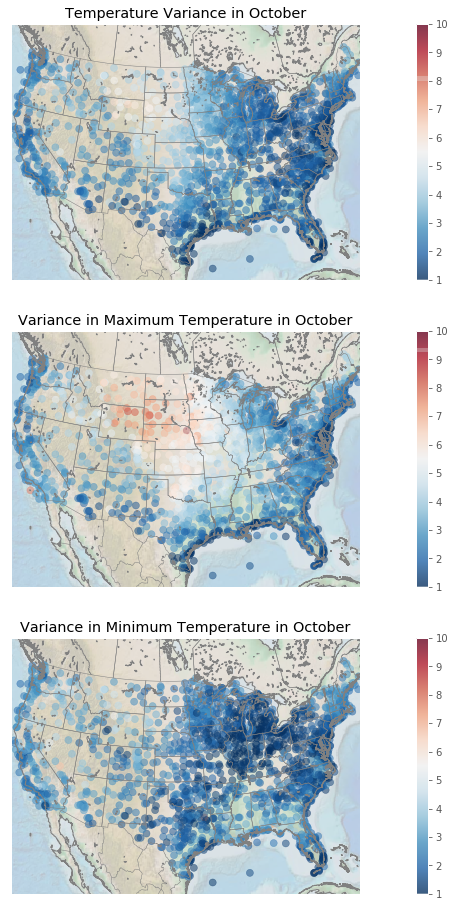

In [17]:
#@title Code for Map Plot
#Code for plotting
df_avg=df.filter(items=['avg_temp_2009','avg_temp_2010','avg_temp_2011','avg_temp_2012','avg_temp_2013','avg_temp_2014'])
df_var_avg=df_avg.transpose().describe().transpose()

df_max = df.filter(items=['max_temp_2009','max_temp_2010','max_temp_2011','max_temp_2012','max_temp_2013','max_temp_2014'])
df_var_max=df_max.transpose().describe().transpose()

df_min = df.filter(items=['min_temp_2009','min_temp_2010','min_temp_2011','min_temp_2012','min_temp_2013','min_temp_2014'])
df_var_min=df_min.transpose().describe().transpose()

# Extract the data we're interested in
lat = df['lat'].values
lon = df['lon'].values

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(20, 16))

temp_std_avg = df_var_avg['std'].values
temp_std_max = df_var_max['std'].values
temp_std_min = df_var_min['std'].values

# 1. Draw the map background
#fig = plt.figure(figsize=(14, 10))
ax1.set_title("Temperature Variance in {}".format(month_dict[month_chosen]))
m1 = Basemap(projection='lcc', resolution='h',llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49, 
          lat_0=45, lon_0=-100, ax = ax1)
m1.etopo(scale=0.5, alpha=0.2)
# m.shadedrelief()
m1.drawcoastlines(color='gray')
m1.drawcountries(color='gray')
m1.drawstates(color='gray')
# 2. scatter city data, with color reflecting population
# and size reflecting area
map1 = m1.scatter(lon, lat, latlon=True,
          c=temp_std_avg, s=50, cmap='RdBu_r', alpha=0.5)
map1.set_clim(1,10)
fig.colorbar(map1, ax=ax1)

# gif_files.append("Jan_var{}.png".format(year))
# plt.savefig("Jan_var{}.png".format(year))
#for max temp
ax2.set_title("Variance in Maximum Temperature in {}".format(month_dict[month_chosen]))
m2 = Basemap(projection='lcc', resolution='h',llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49, 
          lat_0=45, lon_0=-100, ax=ax2)
m2.etopo(scale=0.5, alpha=0.2)
# m.shadedrelief()
m2.drawcoastlines(color='gray')
m2.drawcountries(color='gray')
m2.drawstates(color='gray')
# 2. scatter city data, with color reflecting population
# and size reflecting area
map2 = m2.scatter(lon, lat, latlon=True,
          c=temp_std_max, s=50, cmap='RdBu_r', alpha=0.5)
map2.set_clim(1,10)
fig.colorbar(map2, ax=ax2)
#ax2.clim(1, 10)

#for min temp
ax3.set_title("Variance in Minimum Temperature in {}".format(month_dict[month_chosen]))
m3 = Basemap(projection='lcc', resolution='h',llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49, 
          lat_0=45, lon_0=-100, ax=ax3)
m3.etopo(scale=0.5, alpha=0.2)
# m.shadedrelief()
m3.drawcoastlines(color='gray')
m3.drawcountries(color='gray')
m3.drawstates(color='gray')
# 2. scatter city data, with color reflecting population
# and size reflecting area
map3 = m3.scatter(lon, lat, latlon=True,
          c=temp_std_min, s=50, cmap='RdBu_r', alpha=0.5)
map3.set_clim(1,10)
fig.colorbar(map3, ax = ax3)

plt.show()

# **Insights**


*   Central region of the US recorded a much higher fluctuation in maximum temperature for October month from 2009 to 2019 than other regions
*   Average and Minimum temperatures had relatively less fluctuations than maximum temperature

